- [Forward Problem](#Forward-Problem)
    - [Verify Assumption 1](#Verify-Assumption-1)
    - [Verify Lemma 1](#Verify-Lemma-1)
    - [Verify Theorem 3.1](#Verify-Theorem-3.1)
- [Inverse Problem](#Inverse-Problem)
    - [Verify Assumption 2](#Verify-Assumption-2)
    - [Verify Theorem 4.2](#Verify-Theorem-4.2)

In [1]:
import numpy as np
import numpy.polynomial.legendre as leg
from scipy.stats import norm
from scipy.stats import uniform
from scipy.integrate import odeint
from scipy.stats import gaussian_kde as kde
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
####### Plot Formatting ######
plt.rc('lines', linewidth = 2)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('legend',fontsize=14)
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['lines.markersize'] = 8
plt.rcParams['figure.figsize'] = (8.0, 6.0)

## Example from Xiu2002

$$ \frac{dy(t)}{dt} = -\lambda y, \ \  y(0)=1 $$
$$ y(t) = e^{-\lambda t} $$
$$QoI = y(0.5)$$

$\lambda\sim U[-1,1]$, $t\in[0,1]$

$\Lambda = [-1,1]$, $\mathcal{D}=[e^{-1},e]$

In [3]:
def Phi(n):
    '''Define L_n'''
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def inner2_leg(n):       
    return 2/(2*n+1)

def product3_leg(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: leg.legval(x, leg.legmul(leg.legmul(Phi(i),Phi(j)),Phi(l))) 

def inner3_leg(i,j,l):
    '''
    compute <\Phi_i\Phi_j\Phi_l>    
    Set up Gauss-Legendra quadrature
    '''

    x, w=leg.leggauss(20) 
    inner=sum([product3_leg(i,j,l)(x[idx]) * w[idx] for idx in range(20)])         
    
    return inner  

In [4]:
def ode_system_leg(y, t, P):   
    '''P indicates highest order of Polynomial we use'''
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_leg(i,j,l)*ki_leg[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_leg(l)
    return dydt

In [5]:
P=5
ki_leg = [0,1]+[0]*(P-1)
sol_leg = odeint(ode_system_leg, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P,)) 

In [6]:
def a(i):
    return sol_leg[:,i][50]
coef = np.array([a(0), a(1), a(2), a(3), a(4), a(5)])   #fixed

def Q(i,x):
    return leg.legval(x,coef[:(i+1)])

def Qexact(x):
    return np.exp(-x*0.5)

In [7]:
#### Use plot to show the difference between the exact and approximate map #####
fig = plt.figure()

def plot_Qn(n):
    fig.clear()
    x = np.linspace(-3,3,100)
    y = Qexact(x)
    yn = Q(n, x)
    plt.plot(x,y,linestyle='-.',linewidth=4,label="$Q(\lambda)$")
    plt.plot(x,yn,label='Q_'+str(n)+'$(\lambda)$')
    plt.xlabel('$\Lambda$')
    plt.legend();
    
interact(plot_Qn, 
         n = widgets.IntSlider(value=1,min=1,max=5,step=1))  

<Figure size 576x432 with 0 Axes>

interactive(children=(IntSlider(value=1, description='n', max=5, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.plot_Qn(n)>

## Forward Problem

$\lambda\sim U([-1,1])$, QOI is the value at $t=0.5$ ($y(0.5)$). $Q_n$ defines the Polynomial Chaos expansion with degree $n$.

$$
Q(\lambda)=y(0.5)=\sum\limits_{i=0}^{\infty} y_i(0.5)\Phi_i
$$
$$
Q_n(\lambda)=\sum\limits_{i=0}^n y_i(0.5)\Phi_i
$$

Verify Result of Lemma 2:

$Q_n(\lambda)\to Q(\lambda)$ in $L^p(\Lambda)$, if Assumptions 1 holds and $D_c\subset\mathcal{D}$ being compact, then 
\begin{equation}
	\pi_{\mathcal{D}}^{Q_n}(q) \to \pi_{\mathcal{D}}^{Q}(q) \text{ almost in} {L^r(D_c)}   
\end{equation}

Verify Result of Theorem 3.1:

$Q_n(\lambda)\to Q(\lambda)$ in $L^p(\Lambda)$, if Assumptions 1 holds, $\{\pi_{\mathcal{D}}^{Q_n}\}$ are uniformly integrable in $L^p(\mathcal{D})$, $\mathcal{D}$ is compact, then 
\begin{equation}
        \pi_{\mathcal{D}}^{Q_n}(Q_n(\lambda)) \to \pi_{\mathcal{D}}^{Q}(Q(\lambda)) \text{ in } L^p(\Lambda) 
\end{equation}

### Verify Assumption 1

In [10]:
#Verify Assumption 1

fig=plt.figure()

def plot_pushforward(n,J):
    fig.clear()
    np.random.seed(123456)
    initial_sample = np.random.uniform(-1,1,size = J)
    
    pfprior_sample = Qexact(initial_sample)
    pfprior_dens = kde(pfprior_sample)
    
    pfprior_sample_n = Q(n,initial_sample)
    pfprior_dens_n = kde(pfprior_sample_n)
    
    fig.clear()
    x = np.linspace(-1,3,1000)
    y = pfprior_dens(x)
    yn = pfprior_dens_n(x)
    plt.plot(x,y,color='r', linestyle='-.', linewidth=4, label="$\pi_{\mathcal{D}}^Q$")
    plt.plot(x,yn,linewidth=2,label="$\pi_{\mathcal{D}}^{Q_{n}}$")
    plt.title('Lipschitz const. = %4.2f and Bound = %2.2f' %(np.max(np.abs(np.gradient(pfprior_dens_n(x), x))),
                                                                             np.max(pfprior_dens_n(x))))
    plt.xlabel("$\mathcal{D}$")
    plt.legend()
        
interact(plot_pushforward, 
         n = widgets.IntSlider(value=1,min=1,max=5,step=1),
         J = widgets.IntSlider(value=int(1E3),min=int(1E3),max=int(1E5),step=int(1E3)))

<Figure size 576x432 with 0 Axes>

interactive(children=(IntSlider(value=1, description='n', max=5, min=1), IntSlider(value=1000, description='J'…

<function __main__.plot_pushforward(n, J)>

In [11]:
def assumption1(n,J):
    np.random.seed(123456)
    initial_sample = np.random.uniform(-1,1,size = J)
    
    pfprior_sample_n = Q(n,initial_sample)
    pfprior_dens_n = kde(pfprior_sample_n)

    x = np.linspace(-1,3,1000)
    
    return np.round(np.max(np.abs(np.gradient(pfprior_dens_n(x), x))), 2), np.round(np.max(pfprior_dens_n(x)),2)

In [ ]:
size_J = [int(1E3), int(1E4), int(1E5)]
degree_n = [1, 2, 3, 4, 5]

Bound_matrix, Lip_Bound_matrix = np.zeros((3,5)), np.zeros((3,5))

for i in range(3):
    for j in range(5):
        n, J = degree_n[j], size_J[i]
        Lip_Bound_matrix[i,j] = assumption1(n, J)[0]
        Bound_matrix[i,j] = assumption1(n, J)[1]

In [12]:
print('Bound under certain n and J values')
print(Bound_matrix)
print('Lipschitz bound under certain n and J values')
print(Lip_Bound_matrix)

Bound under certain n and J values
[[1.06 1.28 1.24 1.24 1.24]
 [1.03 1.49 1.42 1.42 1.42]
 [1.   1.61 1.49 1.5  1.5 ]]
Lipschitz bound under certain n and J values
[[ 5.58  8.18  7.73  7.76  7.76]
 [ 8.4  14.18 12.97 13.05 13.05]
 [13.45 23.43 21.   21.22 21.21]]


### Verify Lemma 1
**Print out Monte Carlo Approximation of $	\|\pi_{\mathcal{D}}^Q(q)-\pi_{\mathcal{D}}^{Q_n}(q)\|_{L^r(\mathcal{D_c})} $ where $r>0$ and $D_c=[0,1]$**

In [13]:
#Build $\pi_D^Q$ and $\pi_D^{Q,n}$, use 10,000 samples
N_kde = int(1E4)
N_mc = int(1E4)

np.random.seed(123456)
initial_sample = np.random.uniform(-1,1,size = N_kde)
pfprior_sample = Qexact(initial_sample)
pfprior_dens = kde(pfprior_sample)

def pfprior_dens_n(n,x):
    pfprior_sample_n = Q(n,initial_sample)
    pdf = kde(pfprior_sample_n)
    return pdf(x)

In [14]:
error_r_D = np.zeros((5,5))
np.random.seed(123456)            
qsample = np.random.uniform(0,1,N_mc)

for i in range(5):
    for j in range(5):
        error_r_D[i,j] = (np.mean((np.abs(pfprior_dens(qsample) - pfprior_dens_n(j+1,qsample)))**(i+1)))**(1/(i+1))

In [15]:
np.set_printoptions(linewidth=110)  
print('L^r error on data space for Forward Problem',end='\n\n')
print(error_r_D)        

L^r error on data space for Forward Problem

[[1.37034343e-01 1.40748028e-02 9.35332852e-04 4.65366664e-05 1.92959198e-06]
 [2.08168376e-01 2.35044435e-02 1.53700406e-03 7.76009330e-05 3.22550669e-06]
 [2.50569230e-01 3.00821683e-02 1.92819919e-03 9.69889087e-05 4.00108600e-06]
 [2.79696057e-01 3.51962626e-02 2.22291523e-03 1.10598253e-04 4.54057999e-06]
 [3.01141443e-01 3.92605574e-02 2.45935843e-03 1.20773778e-04 4.95226937e-06]]


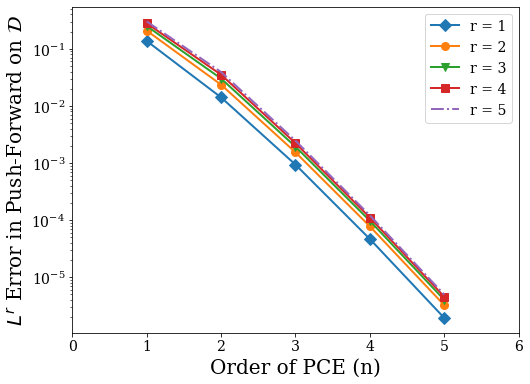

In [16]:
fig = plt.figure()
plt.xlim([0,6])
marker = ['-D', '-o', '-v', '-s', '-.']
for i in range(5):
    plt.semilogy([1,2,3,4,5],error_r_D[i,:],marker[i],label='r = ' + np.str(i+1))    
plt.xlabel('Order of PCE (n)')
plt.ylabel('$L^r$'+' Error in Push-Forward on '+'$\mathcal{D}$')
plt.legend();

### Verify Theorem 3.1
**Print out Monte Carlo Approximation of $	\|\pi_{\mathcal{D}}^Q(Q(\lambda))-\pi_{\mathcal{D}}^{Q_n}(Q_n(\lambda))\|_{L^2(\Lambda)} $**

In [17]:
np.random.seed(123456)       
lamsample = np.random.uniform(-1,1,size = N_mc)

error_2 = np.zeros(5)
for i in range(5):
    error_2[i] = (np.mean((np.abs(pfprior_dens(Qexact(lamsample)) - pfprior_dens_n(i+1,Q(i+1,lamsample))))**2))**(1/2)     

[2.42452472e-01 3.51921960e-02 2.34712105e-03 1.20430887e-04 4.89385277e-06]


In [18]:
np.set_printoptions(linewidth=110)   
print('L^2 error on parameter space for Forward Problem',end='\n\n')
print(error_2)

L^2 error on parameter space for Forward Problem

[2.42452472e-01 3.51921960e-02 2.34712105e-03 1.20430887e-04 4.89385277e-06]


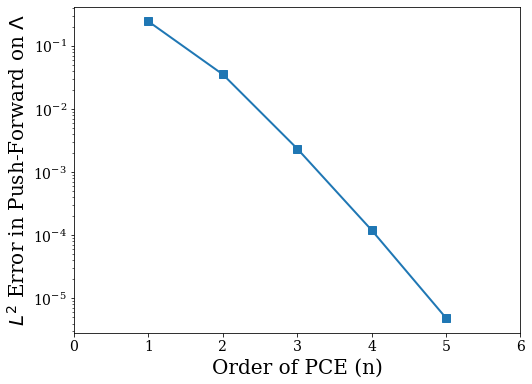

In [19]:
fig = plt.figure()
plt.xlim([0,6])
plt.semilogy([1,2,3,4,5],error_2,'-s')   
plt.xlabel('Order of PCE (n)')
plt.ylabel('$L^2$'+' Error in Push-Forward on '+'$\Lambda$');

## Inverse Problem

Initial guess is $\lambda\sim U([-1,1])$. 

Observation is $\pi_{\mathcal{D}}\sim N(1,0.1^2)$

Verify Result of Theorem 4.2:

$Q_n(\lambda)\to Q(\lambda)$ in $L^p(\Lambda)$, $\pi_{\Lambda}^i\in L^p(\mathcal{D})$. If Assumptions 1, 2 hold, $\{\pi_{\mathcal{D}}^{Q_n}\}$ are uniformly integrable in $L^p(\mathcal{D})$, then 
\begin{equation}
        \pi_{\Lambda}^{u,n}(\lambda) \to \pi_{\Lambda}^{u}(\lambda) \text{ in } L^p(\Lambda) 
\end{equation}

In [20]:
def pdf_obs(x):
    return norm.pdf(x, loc=1, scale=0.1)

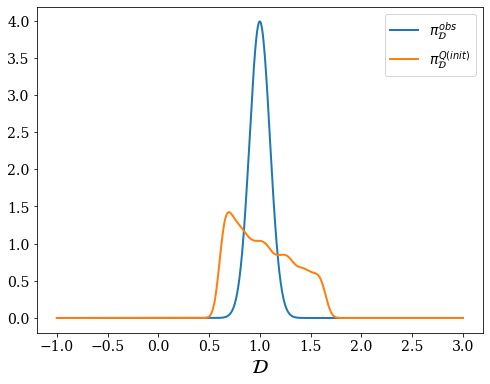

In [21]:
fig = plt.figure()
xx = np.linspace(-1,3,1000)
y = pdf_obs(xx)
y_pf = pfprior_dens(xx)
plt.plot(xx,y,label="$\pi_{\mathcal{D}}^{obs}$")
plt.plot(xx,y_pf, label="$\pi_{\mathcal{D}}^{Q(init)}$")
plt.xlabel("$\mathcal{D}$")
plt.legend();

### Verify Assumption 2

In [22]:
def Meanr(n):
    pfprior_sample_n = Q(n,initial_sample)
    if n==0:
        r = pdf_obs(pfprior_sample)/pfprior_dens(pfprior_sample)
    else:
        r = pdf_obs(pfprior_sample_n)/pfprior_dens_n(n,pfprior_sample_n)
    return np.mean(r)
 

def pdf_update(n,x):
    if n==0:
        r = pdf_obs(pfprior_sample)/pfprior_dens(pfprior_sample)
        pdf = kde(initial_sample,weights=r)
    else:
        pfprior_sample_n = Q(n,initial_sample)
#         pfprior_dens_n = kde(pfprior_sample_n)
        r = pdf_obs(pfprior_sample_n)/pfprior_dens_n(n,pfprior_sample_n)
        pdf = kde(initial_sample,weights=r)
    return pdf(x)

Expect_r = np.zeros(6)
for i in range(6):
    Expect_r[i] = Meanr(i)

In [23]:
print('Expected ratio for verifying Assumption 2')
print(Expect_r[1:])

Expected ratio for verifying Assumption 2
[0.99908545 0.9979389  0.99903931 0.9990585  0.99904968]


In [25]:
#### Use plot to show the difference between the initial, updated, approximate updated #####
fig=plt.figure()

def plot_update(n):
    fig.clear()
    xx = np.linspace(-1.1,1.1,100)
    plt.plot(xx, uniform.pdf(xx, loc=-1, scale=2), label="Initial Density")
    plt.plot(xx, pdf_update(0,xx), label="$\pi_{\Lambda}^u$")
    plt.plot(xx, pdf_update(n,xx), label="$\pi_{\Lambda}^{u,n}$, n="+str(n))
    plt.legend()
    plt.xlabel("$\Lambda$")
    plt.title('$\mathbb{E}(r) =$ %3.2f' %(Expect_r[n]));
    
interact(plot_update, 
         n = widgets.IntSlider(value=int(1),min=int(1),max=int(5),step=1))

<Figure size 576x432 with 0 Axes>

interactive(children=(IntSlider(value=1, description='n', max=5, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.plot_update(n)>

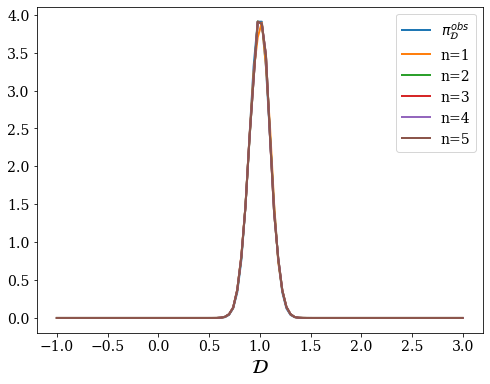

In [26]:
#### Use plot to show the difference between the observed and the pushforward of the approximate updated pdf #####
def update_pushforward(n,x):
    pfprior_sample_n = Q(n,initial_sample)
    r = pdf_obs(pfprior_sample_n)/pfprior_dens_n(n,pfprior_sample_n)
    pdf = kde(pfprior_sample_n,weights=r)
    return pdf(x)

fig = plt.figure()
xx = np.linspace(-1,3,100)
y = pdf_obs(xx)
plt.plot(xx,y,label="$\pi_{\mathcal{D}}^{obs}$")
for i in range(1,6,1):
    y_pf = update_pushforward(i,xx)
    plt.plot(xx,y_pf, label="n="+str(i))
plt.xlabel("$\mathcal{D}$")
plt.legend();

### Verify Theorem 4.2

Print out Monte Carlo Approximation of $\|\pi_{\Lambda}^{u,n}(\lambda)-\pi_{\Lambda}^u(\lambda)\|_{L^2(\Lambda)} $ 

In [27]:
np.random.seed(123456)     
lamsample = np.random.uniform(-1,1,size = N_mc)

error_update = np.zeros(5)
for i in range(5):
    error_update[i] = (np.mean((np.abs(pdf_update(0,lamsample) - pdf_update(i+1,lamsample)))**2))**(1/2)

In [28]:
np.set_printoptions(linewidth=110)
print('L^2 Error for Inverse Problem',end='\n\n')
print(error_update)      

L^2 Error for Inverse Problem

[2.55451741e-01 1.75918768e-02 1.53142778e-03 7.77912615e-05 3.51810288e-06]


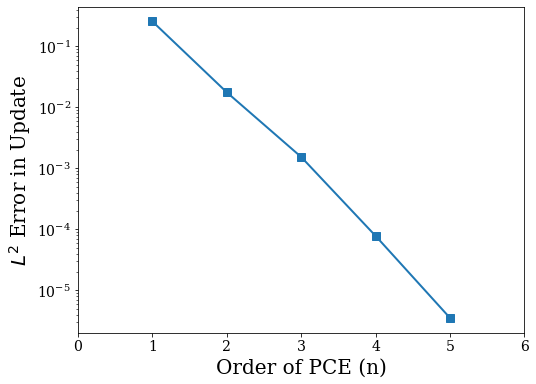

In [29]:
fig = plt.figure()
plt.xlim([0,6])
plt.semilogy([1,2,3,4,5],error_update,'-s')   
plt.xlabel('Order of PCE (n)')
plt.ylabel('$L^2$'+' Error in Update');